In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

infile = "results.pkl"
outfile = "perfChanges.pkl"
outfile2 = "accuracy.pkl"
rawData = []
accuracy = []
samples = 10000
CI99 = 100 - 99 # 99% conf
df_results = pd.read_pickle(infile)

analysis for platform google ...
analysis for regression 10% ...
analysis for wrapper count 10...
analysis for calls 10...
analysis for iterations 1...
    faasterBench detects 16.15% [12.93%, 25.00%].
    traditional detects 14.89% [10.21%, 18.55%].
analysis for iterations 3...
    faasterBench detects 9.67% [6.93%, 11.35%].
    traditional detects 5.62% [4.38%, 11.71%].
analysis for calls 25...
analysis for iterations 1...
    faasterBench detects 14.29% [12.49%, 16.70%].
    traditional detects 12.28% [8.58%, 16.55%].
analysis for iterations 3...
    faasterBench detects 8.43% [6.64%, 10.59%].
    traditional detects 12.40% [7.80%, 14.76%].
analysis for calls 50...
analysis for iterations 1...
    faasterBench detects 15.12% [13.93%, 16.87%].
    traditional detects 11.36% [8.29%, 14.68%].
analysis for iterations 3...
    faasterBench detects 10.81% [9.87%, 11.95%].
    traditional detects 8.66% [5.28%, 12.22%].
analysis for wrapper count 5...
analysis for calls 10...
analysis for i

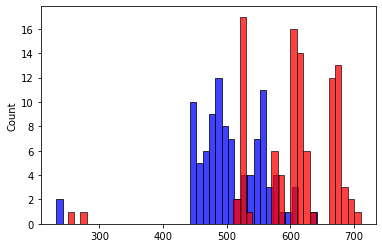

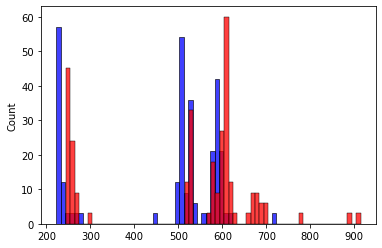

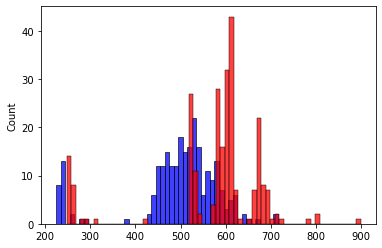

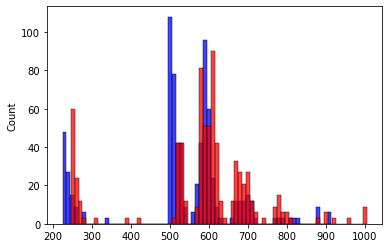

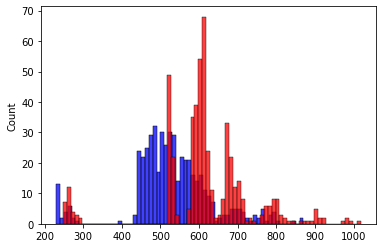

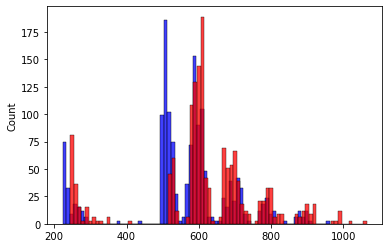

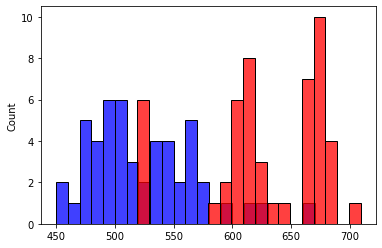

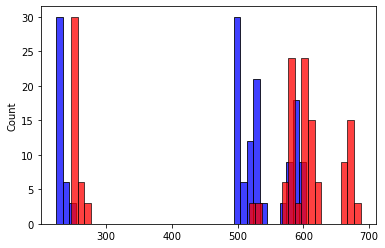

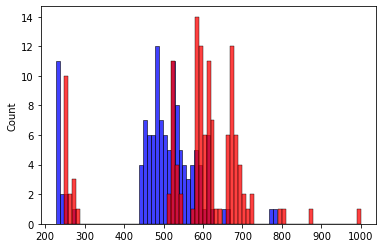

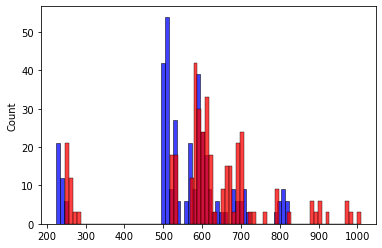

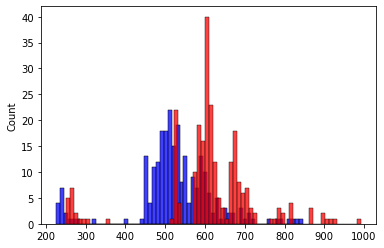

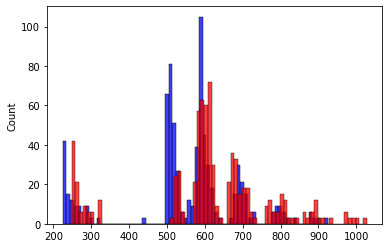

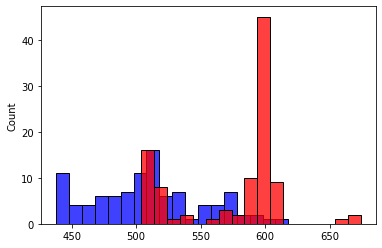

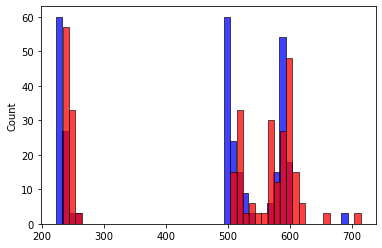

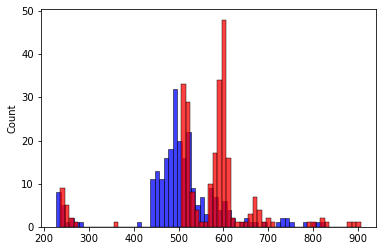

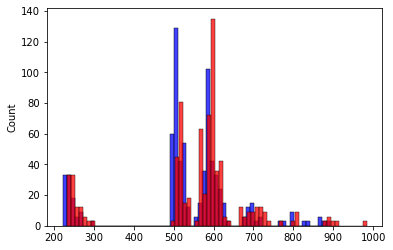

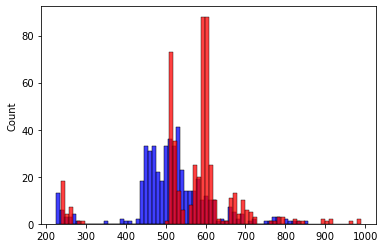

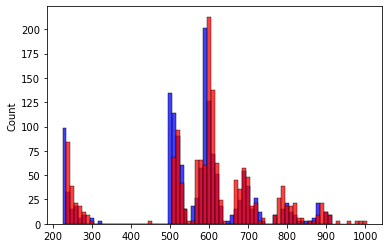

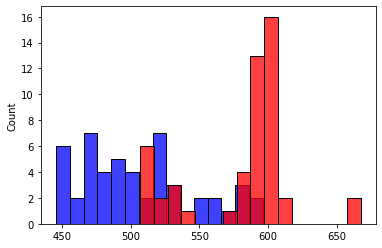

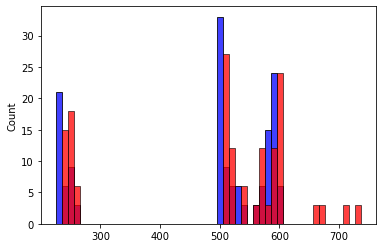

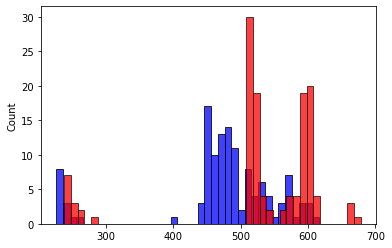

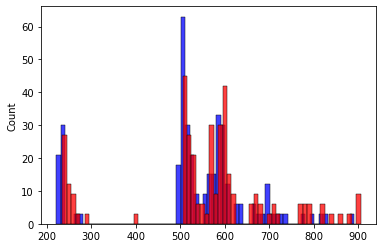

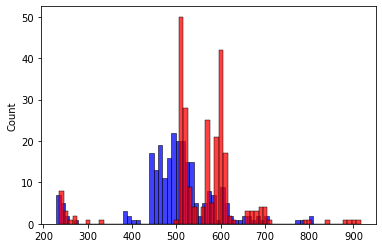

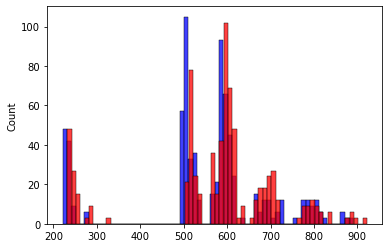

In [2]:
platforms = df_results.platform.unique()
for platform in platforms:
    print("analysis for platform " + platform + " ...")


    regressions = df_results.regression.unique()
    for regression in regressions:
        print("analysis for regression " + str(regression) + "% ...")

        wrapperCounts = df_results.wrapperCount.unique()
        for wrapperCount in wrapperCounts:
            print("analysis for wrapper count " + str(wrapperCount) + "...")

            callsPerFunctions = df_results.callsPerFunction.unique()
            for calls in callsPerFunctions:
                print("analysis for calls " + str(calls) + "...")

                iterations = df_results.iterations.unique()
                for it in iterations:
                    print("analysis for iterations " + str(it) + "...")

                    # faasterBench
                    changes = df_results.loc[(df_results["mode"] == 'modeA')
                                             & (df_results["platform"] == platform)
                                             & (df_results["regression"] == regression)
                                             & (df_results["wrapperCount"] == wrapperCount)
                                             & (df_results["callsPerFunction"] == calls)
                                             & (df_results["iterations"] == it),'change'].to_numpy()

                    run1 = df_results.loc[(df_results["mode"] == 'modeA')
                                             & (df_results["platform"] == platform)
                                             & (df_results["regression"] == regression)
                                             & (df_results["wrapperCount"] == wrapperCount)
                                             & (df_results["callsPerFunction"] == calls)
                                             & (df_results["iterations"] == it),'f1'].to_numpy()
                    run2 = df_results.loc[(df_results["mode"] == 'modeA')
                                             & (df_results["platform"] == platform)
                                             & (df_results["regression"] == regression)
                                             & (df_results["wrapperCount"] == wrapperCount)
                                             & (df_results["callsPerFunction"] == calls)
                                             & (df_results["iterations"] == it),'f2'].to_numpy()

                    #sns.histplot(run1, binwidth=10, color="blue")
                    #sns.histplot(run2, binwidth=10, color="red")
                    plt.show()

                    medPerfChange = (np.median(changes) - 1) * 100
                    manySamples = []
                    for i in range (0,samples):
                        simulatedExperiment = random.choices(changes, k=len(changes))
                        manySamples.append(np.median(simulatedExperiment))

                    manySamples.sort()

                    #medPerfChange = (manySamples[int(len(manySamples)/2)] - 1) * 100
                    small = int((samples * CI99) / 100 / 2)
                    if small == 0:
                        small  = 1
                    min = manySamples[small-1]
                    min = (min - 1) * 100
                    max = manySamples[samples-small-1]
                    max = (max - 1) * 100

                    print(f"    faasterBench detects {medPerfChange:.2f}% [{min:.2f}%, {max:.2f}%].")
                    row = {}
                    row["platform"] = platform
                    row["regression"] = regression
                    row["wrapperCount"] = wrapperCount
                    row["callsPerFunction"] = calls
                    row["iterations"] = it
                    row["method"] = "faasterBench"
                    row["change"] = medPerfChange
                    row["min"] = min
                    row["max"] = max
                    rawData.append(row)

                    row2 = {}
                    row2["method"] = "faasterBench"
                    row2["regression"] = regression
                    row2["measurements"] = len(changes)
                    row2["deviation"] = abs(medPerfChange-regression)
                    row2["CIWidth"] = abs(max-min)
                    accuracy.append(row2)


                    # traditional
                    durations1 = df_results.loc[(df_results["mode"] == 'modeB')
                                             & (df_results["platform"] == platform)
                                             & (df_results["regression"] == regression)
                                             & (df_results["wrapperCount"] == wrapperCount)
                                             & (df_results["callsPerFunction"] == calls)
                                             & (df_results["iterations"] == it),'f1'].to_numpy()
                    durations2 = df_results.loc[(df_results["mode"] == 'modeC')
                                             & (df_results["platform"] == platform)
                                             & (df_results["regression"] == regression)
                                             & (df_results["wrapperCount"] == wrapperCount)
                                             & (df_results["callsPerFunction"] == calls)
                                             & (df_results["iterations"] == it),'f2'].to_numpy()


                    durations1.sort()
                    durations2.sort()
                    pairs = []
                    for d1 in durations1:
                        for d2 in durations2:
                            pairs.append(d2/d1)

                    #medPerf1 = np.median(durations1)
                    #medPerf2 = np.median(durations2)
                    #medPerfChange = ((medPerf2 / medPerf1) - 1) * 100

                    medPerfChange = (np.median(pairs) - 1 ) * 100

                    manySamples = []
                    for i in range (0,samples):
                        simulatedExperiment = []
                        for i in range(0,len(durations1)):
                            simulatedExperiment.append(random.choice(durations2) / random.choice(durations1))

                        manySamples.append(np.median(simulatedExperiment))

                    manySamples.sort()

                    #medPerfChange = (manySamples[int(len(manySamples)/2)] - 1) * 100
                    small = int((samples * CI99) / 100 / 2)
                    if small == 0:
                        small  = 1
                    min = manySamples[small-1]
                    min = (min - 1) * 100
                    max = manySamples[samples-small-1]
                    max = (max - 1) * 100

                    print(f"    traditional detects {medPerfChange:.2f}% [{min:.2f}%, {max:.2f}%].")
                    row = {}
                    row["platform"] = platform
                    row["regression"] = regression
                    row["wrapperCount"] = wrapperCount
                    row["callsPerFunction"] = calls + " "
                    row["iterations"] = it
                    row["method"] = "traditional"
                    row["change"] = medPerfChange
                    row["min"] = min
                    row["max"] = max
                    rawData.append(row)

                    row2 = {}
                    row2["method"] = "traditional"
                    row2["regression"] = regression
                    row2["measurements"] = len(durations1)
                    row2["deviation"] = abs(medPerfChange-regression)
                    row2["CIWidth"] = abs(max-min)
                    accuracy.append(row2)


In [3]:
df_changes = pd.DataFrame(rawData)
df_changes.head()
df_changes.describe()
df_changes.to_pickle(outfile)

In [4]:
df_accuracy = pd.DataFrame(accuracy)
df_accuracy.head()
df_accuracy.describe()
df_accuracy.to_pickle(outfile2)
